<a href="https://colab.research.google.com/github/Ajay-ee13/ML-in-finance/blob/main/1.Stock%20Price%20Prediction/Stock_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

One of the biggest challenges in finance is predicting stock prices. Machine learning techniques naturally lend themselves to stock price prediction based 
on historical data. Predictions can be made for a single time point ahead or for a set of future time points.

other than the historical price of the stock itself, the features that are generally useful for stock price prediction are as follows:
- **Correlated assets** : An organization depends on and interacts with many external factors, including its competitors, clients, the global economy, the geopolitical situation, fiscal and monetary policies, access to capital, and so on. Hence, its stock price may be correlated not only with the stock price of other companies but also with other assets such as commodities, FX, broad-based indices, or even fixed income securities.
- **Technical indicators** : 
- **Fundamental analysis** : Two primary data sources to glean features that can be used in fundamental analysis include:

  - **Performance reports** : Annual and quarterly reports of companies can be used to extract or determine key metrics, such as ROE (Return on Equity) and P/E (Price-toEarnings).
  - **News** : News can indicate upcoming events that can potentially move the stock price in a certain direction.

  

## Problem Definition
We will predict weekly return of the Microsoft stock. For this, other than the historical data of Microsoft, we will be using following potentially correlated assets as the independent variables :

- Stocks: IBM (IBM) and Alphabet (GOOGL)
- Currency: USD/JPY and GBP/USD
- Indices: S&P 500, Dow Jones and VIX

#  Loading the python packages

In [1]:
# Load libraries
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import yfinance as yf
from matplotlib import pyplot
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neural_network import MLPRegressor

#Libraries for Deep Learning Models
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
from keras.layers import LSTM
from keras.wrappers.scikit_learn import KerasRegressor

#Libraries for Statistical Models
import statsmodels.api as sm

#Libraries for Saving the Model
from pickle import dump
from pickle import load

# Time series Models
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Error Metrics
from sklearn.metrics import mean_squared_error

# Feature Selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression


#Plotting 
from pandas.plotting import scatter_matrix
from statsmodels.graphics.tsaplots import plot_acf

In [2]:
#Disable the warnings
import warnings
warnings.filterwarnings('ignore')

# Loading the Data
Loading of data from the YFINANCE and FRED websites using the Pandas DataReader function:

In [3]:
stk_tickers = ['MSFT', 'IBM', 'GOOGL']
ccy_tickers = ['DEXJPUS', 'DEXUSUK']
idx_tickers = ['SP500', 'DJIA', 'VIXCLS']

ccy_data = web.DataReader(ccy_tickers, 'fred')
idx_data = web.DataReader(idx_tickers, 'fred')
yf.pdr_override()
stk_data = web.get_data_yahoo(stk_tickers)

[*********************100%***********************]  3 of 3 completed


In [6]:
return_period = 5

We now define our Y series and our X series

Y: MSFT Future Returns

X:
- GOOGL 5 Business Day Returns
- IBM 5 Business Day Returns    
- USD/JPY 5 Business Day Returns    
- GBP/USD 5 Business Day Returns    
- S&P 500 5 Business Day Returns    
- Dow Jones 5 Business Day Returns    
- MSFT 5 Business Day Returns    
- MSFT 15 Business Day Returns    
- MSFT 30 Business Day Returns    
- MSFT 60 Business Day Returns

In [18]:
Y = np.log(stk_data.loc[:, ('Adj Close', 'MSFT')]).diff(return_period).shift(-return_period)
Y.name = Y.name[-1]+'_pred'

X1 = np.log(stk_data.loc[:, ('Adj Close', ('GOOGL', 'IBM'))]).diff(return_period)
X1.columns = X1.columns.droplevel()
X2 = np.log(ccy_data).diff(return_period)
X3 = np.log(idx_data).diff(return_period)

X4 = pd.concat([np.log(stk_data.loc[:, ('Adj Close', 'MSFT')]).diff(i) for i in [return_period, return_period*3, return_period*6, return_period*12]], axis=1).dropna()
X4.columns = ['MSFT_DT', 'MSFT_3DT', 'MSFT_6DT', 'MSFT_12DT']

X = pd.concat([X1, X2, X3, X4], axis=1)

dataset = pd.concat([Y, X], axis=1).dropna().iloc[::return_period, :]
Y = dataset.loc[:, Y.name]
X = dataset.loc[:, X.columns]

In [20]:
dataset

,MSFT_pred,GOOGL,IBM,DEXJPUS,DEXUSUK,SP500,DJIA,VIXCLS,MSFT_DT,MSFT_3DT,MSFT_6DT,MSFT_12DT
2018-02-21,0.024615,0.055007,0.021070,0.005963,-0.000645,0.001000,-0.003852,0.038701,0.022997,-0.008884,0.040402,0.100751
2018-03-01,0.016873,-0.035294,0.004104,-0.000468,-0.013288,-0.009770,-0.014262,0.182589,0.012136,0.040205,0.034308,0.101765
2018-03-08,-0.002651,0.052693,0.015484,-0.007794,0.005004,0.022635,0.011564,-0.306399,0.016873,0.039089,0.032715,0.119826
2018-03-15,-0.047734,0.018623,0.021532,-0.000094,0.009145,0.003048,-0.000866,0.003018,-0.002651,0.026358,-0.004088,0.085712
2018-03-22,0.016349,-0.088507,-0.048261,-0.006906,0.010482,-0.038454,-0.037512,0.341369,-0.047734,-0.033512,0.006693,0.053527
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-28,-0.053511,-0.034281,-0.008958,0.014327,-0.003153,-0.024858,-0.015117,0.098160,-0.030527,-0.044164,-0.026679,-0.023320
2023-01-05,0.070338,0.002090,0.007754,0.003074,-0.013188,-0.010756,-0.008790,0.046478,-0.053511,-0.144692,-0.085072,-0.027926
2023-01-13,0.013906,0.053284,0.015125,-0.033534,0.010718,0.026353,0.019785,-0.141064,0.061636,-0.021504,-0.064387,0.005870
2023-01-24,0.023559,0.067860,-0.025814,0.014637,0.004799,0.006489,-0.005230,-0.008299,0.007007,0.009214,-0.021903,0.048115


 # Exploratory Data Analysis
 ##  Descriptive Statistics

In [21]:
pd.set_option('precision', 3)
dataset.describe()

,MSFT_pred,GOOGL,IBM,DEXJPUS,DEXUSUK,SP500,DJIA,VIXCLS,MSFT_DT,MSFT_3DT,MSFT_6DT,MSFT_12DT
count,235.000,235.000,2.350e+02,2.350e+02,2.350e+02,2.350e+02,2.350e+02,235.000,235.000,235.000,235.000,235.000
mean,0.005,0.002,-8.371e-04,8.974e-04,-9.783e-04,4.146e-04,1.385e-05,0.003,0.004,0.013,0.024,0.053
std,0.035,0.040,3.555e-02,1.101e-02,1.444e-02,2.721e-02,2.753e-02,0.162,0.036,0.060,0.078,0.101
min,-0.107,-0.132,-1.304e-01,-4.010e-02,-9.152e-02,-1.338e-01,-1.686e-01,-0.485,-0.107,-0.198,-0.246,-0.263
25%,-0.016,-0.016,-1.927e-02,-5.542e-03,-8.258e-03,-7.854e-03,-9.752e-03,-0.092,-0.016,-0.019,-0.019,-0.003
50%,0.010,0.005,3.796e-03,1.232e-03,-6.469e-04,3.815e-03,3.708e-03,-0.018,0.008,0.022,0.034,0.071
75%,0.028,0.023,2.022e-02,7.146e-03,8.257e-03,1.466e-02,1.375e-02,0.083,0.026,0.051,0.078,0.124
max,0.082,0.145,1.263e-01,3.414e-02,5.225e-02,1.072e-01,1.123e-01,0.682,0.101,0.186,0.227,0.346


In [22]:
dataset.head()

,MSFT_pred,GOOGL,IBM,DEXJPUS,DEXUSUK,SP500,DJIA,VIXCLS,MSFT_DT,MSFT_3DT,MSFT_6DT,MSFT_12DT
2018-02-21,0.025,0.055,0.021,5.963e-03,-6.451e-04,0.001,-3.852e-03,0.039,0.023,-0.009,0.040,0.101
2018-03-01,0.017,-0.035,0.004,-4.676e-04,-1.329e-02,-0.010,-1.426e-02,0.183,0.012,0.040,0.034,0.102
2018-03-08,-0.003,0.053,0.015,-7.794e-03,5.004e-03,0.023,1.156e-02,-0.306,0.017,0.039,0.033,0.120
2018-03-15,-0.048,0.019,0.022,-9.427e-05,9.145e-03,0.003,-8.660e-04,0.003,-0.003,0.026,-0.004,0.086
2018-03-22,0.016,-0.089,-0.048,-6.906e-03,1.048e-02,-0.038,-3.751e-02,0.341,-0.048,-0.034,0.007,0.054


## Data Visualization

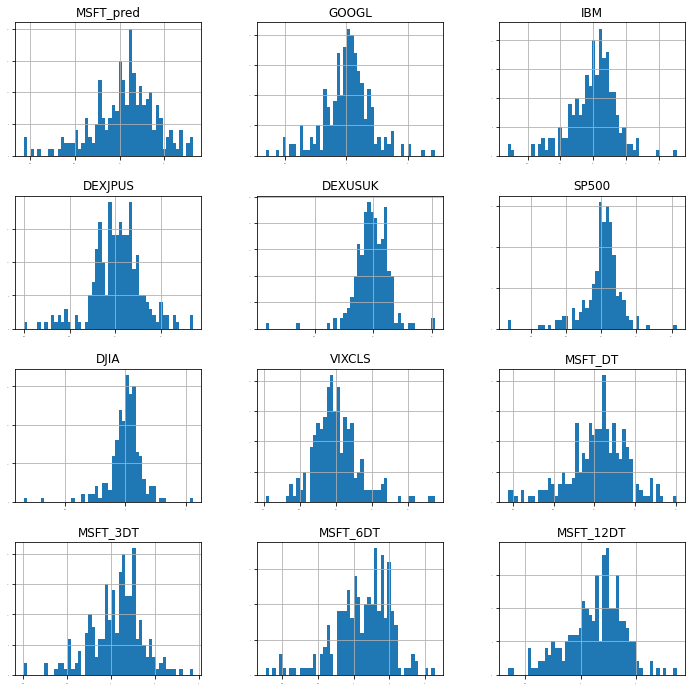

In [23]:
dataset.hist(bins=50, sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(12,12))
pyplot.show()


The above histogram shows the distribution for each series individually. Now, lets look at the density distribution over the same x axis scale.

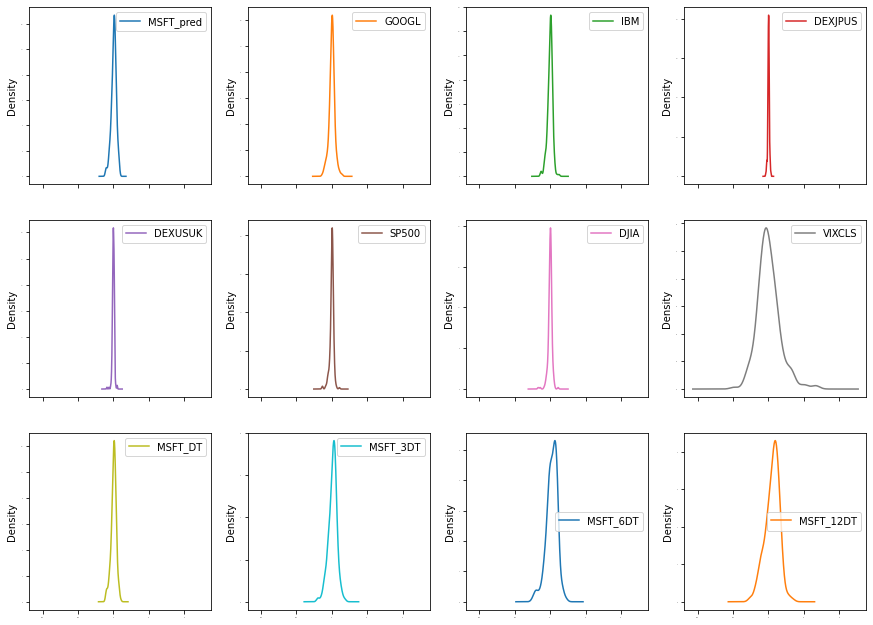

In [24]:
dataset.plot(kind='density', subplots=True, layout=(4,4), sharex=True, legend=True, fontsize=1, figsize=(15,15))
pyplot.show()

We can see that the vix has a much larger variance compared to the other distributions.

In order to get a sense of the interdependence of the data we look at the scatter plot and the correlation matrix

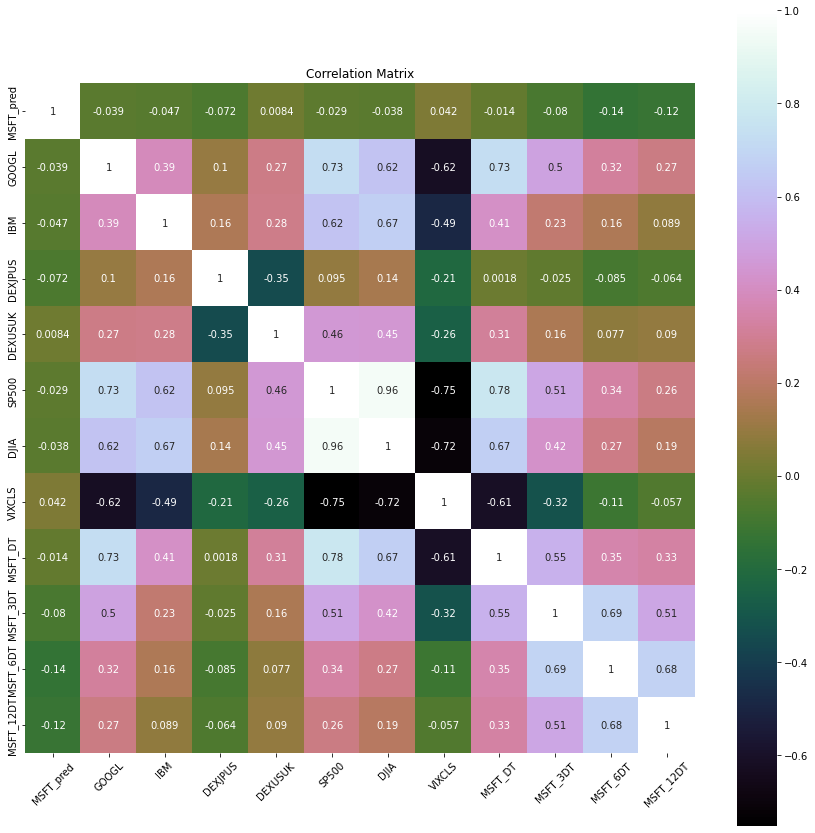

In [34]:
correlation = dataset.corr()
pyplot.figure(figsize=(15,15))
pyplot.title('Correlation Matrix')
pyplot.xticks(rotation = 45)
# sns.heatmap(correlation, vmax=1, square=True,annot=True,linewidth=.5, cmap='cubehelix')
sns.heatmap(correlation, vmax=1, square=True,annot=True, cmap='cubehelix')

Looking at the correlation plot above, we see some correlation of the predicted variable with the lagged 5 days, 15days, 30 days and 60 days return of MSFT. we see a higher negative correlation of many asset returns versus VIX, which is intuitive.

<Figure size 1440x1440 with 0 Axes>

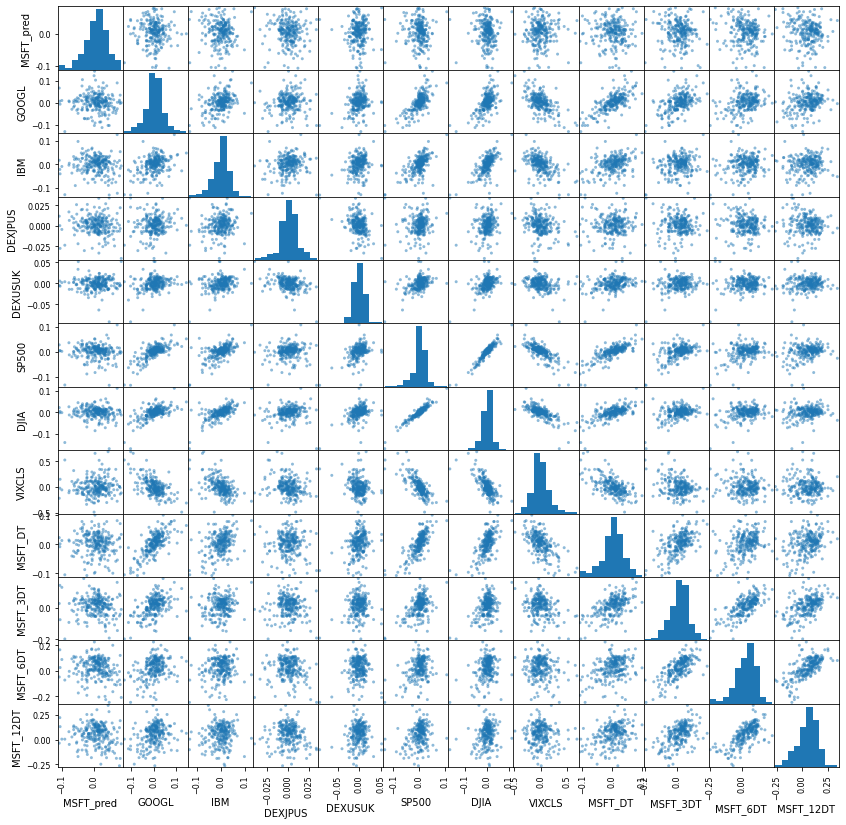

In [39]:
pyplot.figure(figsize=(20,20))
scatter_matrix(dataset,figsize=(14,14))
pyplot.show()


Looking at the scatter plot above, we see some linear relationship of the predicted variable with the lagged 15 days, 30 days and 60 days return of MSFT.

## Time Series Analysis
### Seasonal decomposition of time series

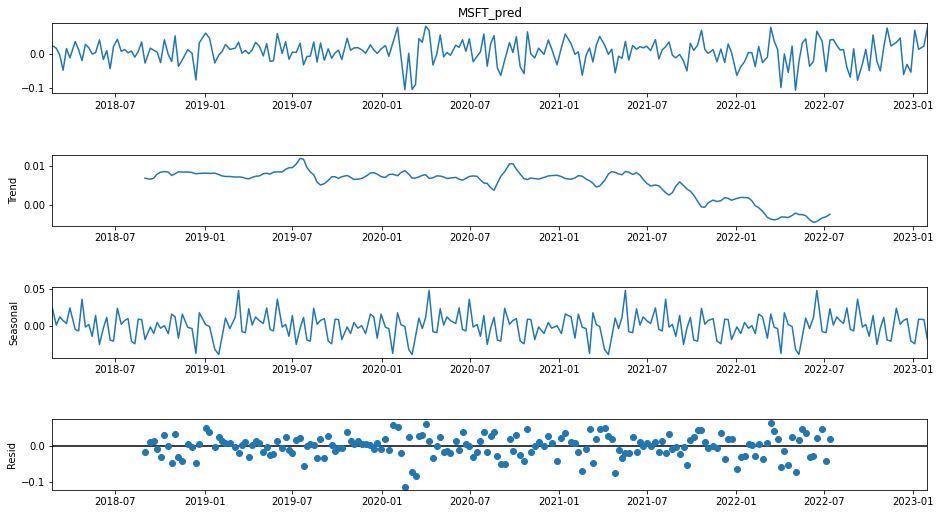

In [40]:
res = sm.tsa.seasonal_decompose(Y,freq=52)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
pyplot.show()